<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
#from functools import reduce

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [2]:
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')

data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [3]:
glu_data = pd.read_sas('data/GLU_H.XPT') # Fasting glucose was not part of the original dataset. Added from NHANES website
vitd_data = pd.read_sas('data/VID_H.XPT')
data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [4]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')


Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health.

In [5]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")

dataset

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,BPXML1,BPXSY1,BPXDI1,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXLEG,BMILEG,BMXARML,...,PAQ755,PAQ759A,PAQ759B,PAQ759C,PAQ759D,PAQ759E,PAQ759F,PAQ759G,PAQ759H,PAQ759I,PAQ759J,PAQ759K,PAQ759L,PAQ759M,PAQ759N,PAQ759O,PAQ759P,PAQ759Q,PAQ759R,PAQ759S,PAQ759T,PAQ759U,PAQ759V,PAQ762,PAQ764,PAQ766,PAQ679,PAQ750,PAQ770,PAQ772A,PAQ772B,PAQ772C,PAAQUEX,PUQ100,PUQ110,RHQ010,RHQ020,RHQ031,RHD043,RHQ060,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U,RXQ510,RXQ515,RXQ520,RXQ525G,RXQ525Q,RXQ525U,RXD530,SLD010H,SLQ050,SLQ060,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD055,SMD057,SMQ078,SMD641,SMD650,SMD093,SMDUPCA,SMD100BR,SMD100FL,SMD100MN,SMD100LN,SMD100TR,SMD100NI,SMD100CO,SMQ621,SMD630,SMQ661,SMQ665A,SMQ665B,SMQ665C,SMQ665D,SMQ670,SMQ848,SMQ852Q,SMQ852U,SMAQUEX2,SMD460,SMD470,SMD480,SMQ856,SMQ858,SMQ860,SMQ862,SMQ866,SMQ868,SMQ870,SMQ872,SMQ874,SMQ876,SMQ878,SMQ880,SMAQUEX.x,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,SMQ690G,SMQ845,SMQ690H,SMQ849,SMQ851,SMQ690D,SMQ800,SMQ690E,SMQ817,SMQ690I,SMQ857,SMQ690J,SMQ861,SMQ863,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX.y,SXD021,SXQ800,SXQ803,SXQ806,SXQ809,SXQ700,SXQ703,SXQ706,SXQ709,SXD031,SXD171,SXD510,SXQ824,SXQ827,SXD633,SXQ636,SXQ639,SXD642,SXQ410,SXQ550,SXQ836,SXQ841,SXQ853,SXD621,SXQ624,SXQ627,SXD630,SXQ645,SXQ648,SXQ610,SXQ251,SXQ590,SXQ600,SXD101,SXD450,SXQ724,SXQ727,SXQ130,SXQ490,SXQ741,SXQ753,SXQ260,SXQ265,SXQ267,SXQ270,SXQ272,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,1.0,1.0,1,1

In [6]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 

#inputs=dataset[['SEQN','Diet spending','Depression score']]
#final_data=final_data.merge(inputs)

final_data

,SEQN,RXDCOUNT,RXDDAYS,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,DR1TALCO,DR1.320Z,LBDGLTSI,LBDGLUSI,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DIQ160,DIQ170,DIQ172,DIQ175A,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,PAD645,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,WHQ030,WHQ070,DBQ700,HSD010,WHD110,WHD120,BMXWT
0,73557,2.0,NaN,1,69,4,26.7,122.0,72.0,114.0,76.0,102.0,74.0,0.0,960.0,NaN,NaN,1.68,4.32,28.9,13.9,NaN,NaN,NaN,NaN,8.0,8.0,0.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,8.0,3.0,NaN,2.0,2.0,270.0,200.0,78.3
1,73558,4.0,243.0,1,54,3,28.6,156.0,62.0,160.0,80.0,156.0,42.0,119.0,360.0,NaN,NaN,1.29,4.40,61.9,9.1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2.0,2.0,1.0,7.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,10.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,540.0,4.0,8.0,3.0,2.0,3.0,4.0,240.0,250.0,89.5
2,73559,5.0,365.0,1,72,3,28.9,140.0,90.0,140.0,76.0,146.0,80.0,0.0,1254.0,NaN,10.713,1.55,3.26,126.0,8.9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,2.0,2.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,7.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,180.0,300.0,4.0,0.0,3.0,2.0,3.0,3.0,180.0,190.0,88.9
4,73561,4.0,152.0,2,73,3,19.7,136.0,86.0,134.0,88.0,142.0,86.0,0.0,240.0,NaN,5.940,2.20,5.20,108.0,4.9,2.0,2.0,2.0,NaN,0.0,NaN,4.0,1.0,2.0,2.0,15.0,15.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,1.0,2.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,480.0,1.0,1.0,2.0,2.0,2.0,5.0,150.0,135.0,52.0
5,73562,7.0,365.0,1,56,1,41.7,160.0,84.0,158.0,82.0,154.0,80.0,0.0,1014.0,NaN,NaN,0.98,5.84,44.3,5.5,2.0,2.0,1.0,NaN,14.0,14.0,0.0,0.0,2.0,2.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,5.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,360.0,5.0,8.0,1.0,1.0,5.0,5.0,225.0,195.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,91.0,1,52,3,25.6,108.0,70.0,112.0,72.0,108.0,76.0,0.0,0.0,NaN,NaN,1.42,3.57,109.0,5.4,2.0,2.0,2.0,NaN,15.0,0.0,0.0,0.0,2.0,2.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,4.0,120.0,1.0,3.0,120.0,240.0,2.0,8.0,3.0,2.0,1.0,2.0,172.0,163.0,79.5
10166,83723,NaN,NaN,1,61,1,33.1,NaN,NaN,138.0,60.0,142.0,68.0,0.0,3000.0,NaN,8.826,1.27,4.81,59.4,7.4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,30.0,360.0,3.0,8.0,1.0,NaN,3.0,4.0,240.0,200.0,99.5
10167,83724,5.0,10950.0,1,80,3,24.9,164.0,70.0,168.0,66.0,168.0,66.0,0.0,690.0,NaN,NaN,1.32,4.06,89.9,5.5,2.0,2.0,2.0,NaN,1.0,1.0,0.0,30.0,2.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,60.0,360.0,2.0,8.0,3.0,2.0,2.0,2.0,173.0,140.0,77.1
10170,83727,NaN,NaN,1,26,2,24.5,110.0,68.0,116.0,74.0,112.0,76.0,14.0,867.0,5.995,5.995,1.42,4.91,81.5,5.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,1.0,3.0,2.0,4.0,3.0,NaN,NaN,71.8


In [7]:
X = final_data.drop('LBXGH', axis=1)
y = np.where(final_data['LBXGH'] >=6.5, 1, 0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

As shown in previous cell, all datasets have been combined and only features related to diabetes and mental health have been filtered out to create the dataset from which analysis will be done.

In [9]:
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data_train = X_train[SES]
SES_data_test = X_test[SES]

Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [10]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))


SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))

In [11]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data_train['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat4, inplace=True)


#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data_train['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat4, inplace=True)

X_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2']
X_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2']
X_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2']
X_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2']

In [12]:
check=[11]
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
SES_data_train['INDHHIN2'].isin(check).sum()

0

In [13]:
#Should be removed before main integration for project submission

SES_data_train['INDFMIN2'].isin(check).sum()

0

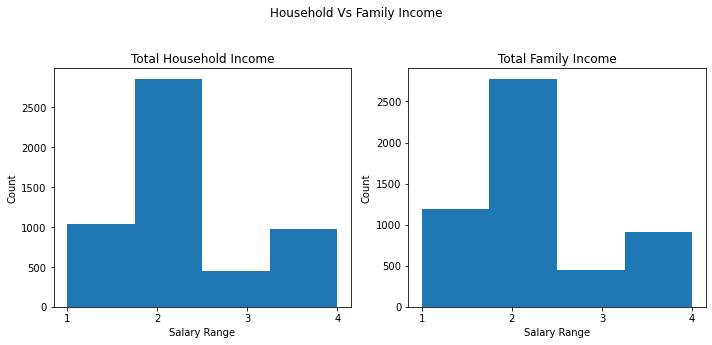

In [14]:
#Plot the income indicators into histograms according to the new catergories that we arranged them in

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data_train['INDHHIN2'], bins=4)
ax1.set_ylabel("Count")
ax1.set_xlabel("Salary Range")
ax1.set_title("Total Household Income")
ax1.set_xticks([1,2,3,4]) 
ax1.set_xticklabels([1,2,3,4])

ax2.hist(SES_data_train['INDFMIN2'], bins=4)
ax2.set_ylabel("Count")
ax2.set_xlabel("Salary Range")
ax2.set_title("Total Family Income")
ax2.set_xticks([1,2,3,4]) 
ax2.set_xticklabels([1,2,3,4])

fig.suptitle("Household Vs Family Income")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
SES_data_train['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSD151'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)
SES_data_test['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)

SES_data_train['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSQ165'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)
SES_data_test['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)


X_train['FSD151'] = SES_data_train['FSD151']
X_train['FSQ165'] = SES_data_train['FSQ165']
X_test['FSD151'] = SES_data_test['FSD151']
X_test['FSQ165'] = SES_data_test['FSQ165']

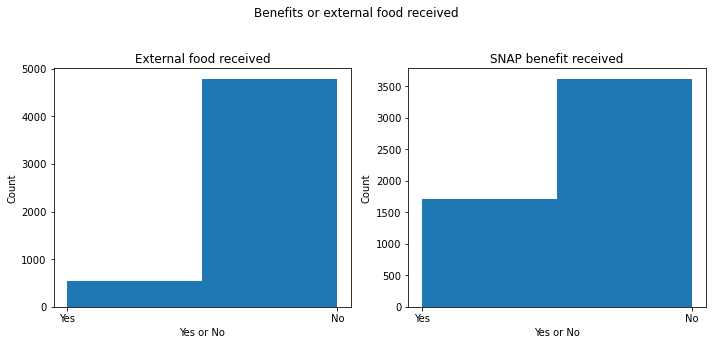

In [16]:
# Features showing benefit

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data_train['FSD151'], bins=2)
ax1.set_ylabel("Count")
ax1.set_xlabel("Yes or No")
ax1.set_title("External food received")
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Yes','No'])

ax2.hist(SES_data_train['FSQ165'], bins=2)
ax2.set_ylabel("Count")
ax2.set_xlabel("Yes or No")
ax2.set_title("SNAP benefit received")
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Yes','No'])

fig.suptitle("Benefits or external food received")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health_train = X_train[mh]
mental_health_test = X_test[mh]

mental_health_train.loc[:,'DPQ_score'] = mental_health_train.drop('SEQN', axis=1).sum(axis=1) # summing up scores
mental_health_test.loc[:,'DPQ_score'] = mental_health_test.drop('SEQN', axis=1).sum(axis=1) # summing up scores

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
X_train.loc[:,'mental_health_stat'] = pd.cut(mental_health_train['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)
X_test.loc[:,'mental_health_stat'] = pd.cut(mental_health_test['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

X_train = X_train.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)
X_test = X_test.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

In [18]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'WHQ030'] = X_train['WHQ030'].fillna(3).replace(9,3) 
X_test.loc[:,'WHQ030'] = X_test['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
X_train.loc[:,'WHQ070'] = X_train['WHQ070'].fillna(2).replace(9,2) 
X_test.loc[:,'WHQ070'] = X_test['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'DBQ700'] = X_train['DBQ700'].fillna(3).replace(9,3)
X_test.loc[:,'DBQ700'] = X_test['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
X_train.loc[:,'HSD010'] = X_train['HSD010'].fillna(3).replace(9,3)
X_test.loc[:,'HSD010'] = X_test['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception_train = X_train[sp]
self_perception_test = X_test[sp]
self_perception_train.loc[:,'WHQ030_score'] = self_perception_train['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_train.loc[:,'WHQ070_score'] = self_perception_train['WHQ070'].replace(1,0)
self_perception_train.loc[:,'DBQ700_score'] = self_perception_train['DBQ700']-1
self_perception_train.loc[:,'HSD010_score'] = self_perception_train['HSD010']-1
self_perception_test.loc[:,'WHQ030_score'] = self_perception_test['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_test.loc[:,'WHQ070_score'] = self_perception_test['WHQ070'].replace(1,0)
self_perception_test.loc[:,'DBQ700_score'] = self_perception_test['DBQ700']-1
self_perception_test.loc[:,'HSD010_score'] = self_perception_test['HSD010']-1

# Creating summary score for self perception
self_perception_train.loc[:,'self_perception_stat'] = self_perception_train[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_train.loc[:,'self_perception_stat'] = pd.cut(self_perception_train.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)
self_perception_test.loc[:,'self_perception_stat'] = self_perception_test[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_test.loc[:,'self_perception_stat'] = pd.cut(self_perception_test.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

X_train = X_train.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)
X_test = X_test.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

In [19]:
# Cleaning number of medications
X_train['RXDCOUNT'] = X_train['RXDCOUNT'].replace(np.NaN, 0)
X_test['RXDCOUNT'] = X_test['RXDCOUNT'].replace(np.NaN, 0)

# Defining average blood pressure
X_train.loc[:,'AVGSYBP'] = round(X_train[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_train.loc[:,'AVGDIBP'] = round(X_train[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))
X_test.loc[:,'AVGSYBP'] = round(X_test[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_test.loc[:,'AVGDIBP'] = round(X_test[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))

# Dropping base features relating to 1,2,3 measurements of Systolic and Diastolic BP
X_train = X_train.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)
X_test = X_test.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

# Cleaning data for DBD895. >21 responses normalized to 21. Unsure participants normalized to mean number of meals based on train set
X_train['DBD895'] = X_train['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_train['DBD900'] = X_train['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))
X_test['DBD895'] = X_test['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_test['DBD900'] = X_test['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))

# Calculating proportion of fast food compared to all other meals consumed outside
avg_meals_train = X_train['DBD900'] / X_train['DBD895']
avg_meals_train = avg_meals_train.replace(np.inf, 0)
avg_meals_train = avg_meals_train.where(avg_meals_train < 1 ,1)
X_train['PROFFMEAL'] = avg_meals_train
avg_meals_test = X_test['DBD900'] / X_test['DBD895']
avg_meals_test = avg_meals_test.replace(np.inf, 0)
avg_meals_test = avg_meals_test.where(avg_meals_test < 1 ,1)
X_test['PROFFMEAL'] = avg_meals_test

X_train['DBD905'] = X_train['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_train['DBD910'] = X_train['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   
X_test['DBD905'] = X_test['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_test['DBD910'] = X_test['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   

X_train.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120','BMXWT','SEQN'],axis=1, inplace=True)
X_test.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120','BMXWT','SEQN'],axis=1, inplace=True)

In [20]:
#Create working database for activity
activity = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity]
activity_wk_test = X_test.loc[:,activity]

#drop "PAQ706" due to poor data
#code out target variable "DM"
#code activity levels
activity1 = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity1]
#activity_wk_train["DM"] = activity_wk_train["LBXGH"]>6.5
activity_wk_train["activity_lvl_high"] = np.where((activity_wk_train.PAQ650 == 1) | (activity_wk_train.PAQ605 == 1), 1, np.NaN)
activity_wk_train["activity_lvl_med"] = np.where((activity_wk_train["PAQ620"] == 1) | (activity_wk_train["PAQ665"] == 1), 2, np.NaN)
activity_wk_train["activity_lvl_low"] =  (activity_wk_train["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)
activity_wk_test = X_test.loc[:,activity1]
#activity_wk_test["DM"] = activity_wk_test["LBXGH"]>6.5
activity_wk_test["activity_lvl_high"] = np.where((activity_wk_test.PAQ650 == 1) | (activity_wk_test.PAQ605 == 1), 1, np.NaN)
activity_wk_test["activity_lvl_med"] = np.where((activity_wk_test["PAQ620"] == 1) | (activity_wk_test["PAQ665"] == 1), 2, np.NaN)
activity_wk_test["activity_lvl_low"] =  (activity_wk_test["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)

activity_wk_train["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_train["activity_lvl_low"].replace(False, np.NaN, inplace=True)
#activity_wk[activity_wk["activity_lvl_high"]==0].replace(0,activity_wk["activity_lvl_med"], inplace=True )
#activity_wk["activity_lvl_high"].replace(0,activity_wk["activity_lvl_med"], inplace =True)
activity_wk_train["activity_lvl"] = activity_wk_train[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)
activity_wk_test["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_test["activity_lvl_low"].replace(False, np.NaN, inplace=True)
activity_wk_test["activity_lvl"] = activity_wk_test[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)


X_train['activity_lvl'] = activity_wk_train['activity_lvl']
X_test['activity_lvl'] = activity_wk_test['activity_lvl']

X_train.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)
X_test.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)

In [21]:
# Reindexing train and test sets for dropping of NA values. 

X_train = X_train.reset_index().drop('index',axis=1)
tmp_train = pd.concat((X_train, pd.DataFrame(y_train)), axis=1)

X_test = X_test.reset_index().drop('index',axis=1)
tmp_test = pd.concat((X_test, pd.DataFrame(y_test)), axis=1)

tmp_train.dropna(axis=0,how='any', inplace = True)
tmp_test.dropna(axis=0,how='any', inplace = True)

In [22]:
X_train = tmp_train.drop(0,axis=1)
y_train = tmp_train.iloc[:,-1]
X_test = tmp_test.drop(0,axis=1)
y_test = tmp_test.iloc[:,-1]

In [23]:
X_train

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,152.0,85.0,0.000000,3.0
1,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,1,2,109.0,65.0,0.000000,3.0
2,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,3,2,170.0,96.0,0.000000,3.0
3,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,0,1,105.0,65.0,0.666667,1.0
4,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,0,1,109.0,68.0,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,0.0,1,36,3,23.6,11.2,180.0,1.19,3.54,73.7,5.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,0,2,119.0,85.0,0.600000,1.0
5309,2.0,2,70,4,22.0,0.0,525.0,1.37,4.97,35.6,5.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0,2,155.0,80.0,0.000000,3.0
5310,7.0,2,74,3,22.1,19.2,1575.0,0.91,5.51,113.0,2.0,0.0,12.0,0.0,2.0,2.0,2.0,2.0,0,2,127.0,57.0,0.000000,3.0
5312,0.0,2,20,4,23.8,0.0,75.0,2.07,4.22,43.9,0.0,5.0,2.0,3.0,2.0,2.0,3.0,3.0,0,1,107.0,67.0,0.000000,1.0


  
  
# DATA ANALYSIS
  
  

In [24]:
#count number of NA for each row
#distrubutions of continuous variables and categorical variables


tmp=final_data[['SEQN','Diabetic']]
input1=final_data.drop(columns=['SEQN','Diabetic'])

colMax=len(input1.columns)
list1=input1.columns.values

lgd=[
    'NO',
    'PREDIABETES',
    'YES',
]

for i in range(0,colMax):
    tmp2=tmp
    feature1=list1[i]
    tmp2[feature1]=input1.iloc[:,i]
    string=list1[i]
    plt.figure(i)
    X1=tmp2[feature1].loc[tmp2['Diabetic']=='YES']
    X2=tmp2[feature1].loc[tmp2['Diabetic']=='PREDIABETES']
    X3=tmp2[feature1].loc[tmp2['Diabetic']=='NO']
    plt.hist(X3,bins=30)
    #plt.axvline(X3.mean(),c='blue')
    plt.hist(X2,bins=30)
    #plt.axvline(X2.mean(),c='orange')
    plt.hist(X1,bins=30)
    #plt.axvline(X1.mean(),c='green')
    plt.title(feature1)
    plt.legend(lgd)
    
plt.show()

KeyError: "['Diabetic'] not in index"

In [27]:
from sklearn.metrics import silhouette_score

b_cluster=[2,3,4,5,6,7,8,9,10]
avg_sil=[]
for n in nb_cluster:
    km=KMeans(n_clusters=n)
    Y1=km.fit_predict(X)
    avg_sil.append(silhouette_score(X,Y1))
    
plt.figure(0)
plt.title('silhouette score for each number of clusters')
plt.plot(nb_cluster,avg_sil)
plt.show()

NameError: name 'nb_cluster' is not defined

In [28]:
X_train

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,152.0,85.0,0.000000,3.0
1,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,1,2,109.0,65.0,0.000000,3.0
2,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,3,2,170.0,96.0,0.000000,3.0
3,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,0,1,105.0,65.0,0.666667,1.0
4,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,0,1,109.0,68.0,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,0.0,1,36,3,23.6,11.2,180.0,1.19,3.54,73.7,5.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,0,2,119.0,85.0,0.600000,1.0
5309,2.0,2,70,4,22.0,0.0,525.0,1.37,4.97,35.6,5.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0,2,155.0,80.0,0.000000,3.0
5310,7.0,2,74,3,22.1,19.2,1575.0,0.91,5.51,113.0,2.0,0.0,12.0,0.0,2.0,2.0,2.0,2.0,0,2,127.0,57.0,0.000000,3.0
5312,0.0,2,20,4,23.8,0.0,75.0,2.07,4.22,43.9,0.0,5.0,2.0,3.0,2.0,2.0,3.0,3.0,0,1,107.0,67.0,0.000000,1.0


In [29]:
X_train.dtypes

RXDCOUNT                 float64
RIAGENDR                   int64
RIDAGEYR                   int64
RIDRETH1                   int64
BMXBMI                   float64
DR1TALCO                 float64
DR1.320Z                 float64
LBDHDDSI                 float64
LBDTCSI                  float64
LBXVIDMS                 float64
DBD895                   float64
DBD900                   float64
DBD905                   float64
DBD910                   float64
FSD151                   float64
FSQ165                   float64
INDHHIN2                 float64
INDFMIN2                 float64
mental_health_stat      category
self_perception_stat    category
AVGSYBP                  float64
AVGDIBP                  float64
PROFFMEAL                float64
activity_lvl             float64
dtype: object

## Logistic Regression

## Decision Trees

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [ ]:
### Converting data columns into appropriate data types for scaling
#cat = ['FSD151','FSQ165','INDHHIN2','INDFMIN2','mental_health_stat','self_perception_stat','activity_lvl']
#X_train[cat] = X_train[cat].astype('object')
#X_test[cat] = X_test[cat].astype('object')

### Data scaling
#numerical_columns_selector = selector(dtype_exclude=object)
#categorical_columns_selector = selector(dtype_include=object)

#numerical_columns = numerical_columns_selector(X_train)
#categorical_columns = categorical_columns_selector(X_train)

#categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
#numerical_preprocessor = StandardScaler()

#preprocessor = ColumnTransformer([
#    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
#    ('standard-scaler', numerical_preprocessor, numerical_columns)])

### Making pipeline with Logistic Regressor

#logreg_pipe = Pipeline(steps = [('preprocess',preprocessor), ('logreg', LogisticRegression(random_state=42,max_iter=500, class_weight='balanced'))])

In [41]:
selector = SelectFromModel(DecisionTreeClassifier(random_state=42, class_weight='balanced'))
selector.fit(X_train,y_train)
selector.get_support()

array([ True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False])

In [42]:
selected_features = X_train.columns[(selector.get_support())]

X_train_support = X_train[selected_features]
X_test_support = X_test[selected_features]

Using sklearn's inbuilt feature selector, we shortlist the features that contribute the largest degree of importance. We will be using these features in the development of the cross-validated decision tree model. The features are as follows:

In [68]:
selected_features

Index(['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'DR1.320Z', 'LBDHDDSI', 'LBDTCSI',
       'LBXVIDMS', 'AVGSYBP'],
      dtype='object')

The above features are (in order): RXDCOUNT: the number of medications the subject is prescribed with; RIDAGEYR: age in years; BMXBMI: Body Mass Index (BMI); DR1.320z: amount of water consumed in the first day of dietary recording; LBDHDDSI: The HDL cholesterol levels; LBDTCSI: Total cholesterol levels; LBXVIDMS: Vitamin D levels; AVGSYBP: Average systolic blood pressure.

As Decision Tree models are not optimised using a measure of Euclidean distance, there will not be a need to normalize the features. As such, we will pass the features directly through the Decision Tree Classifier. A random state of 42 is selected as consistent with the rest of the project and we initialize the 'balanced' class weight argument because of the imbalanced nature of this dataset.

In [136]:
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

To obtain optimal validation scores for the model, we will run the decision tree model using GridSearchCV. This allows us to cross validate the data and select the best model based on the roc auc metric. We hyperparameters that we will be tuning would be the criterion and the max depth parameters of the decision tree. 

In [137]:
param_grid = {'criterion': ['gini','entropy'],'max_depth':[5,7,9,11,13,15]}

tree_cv = GridSearchCV(tree_model, param_grid,scoring='roc_auc', cv=5)

In [138]:
tree_cv.fit(X_train_support,y_train)
tree_cv.best_params_

{'criterion': 'entropy', 'max_depth': 5}

The chosen parameters for the Decision Tree model are using the entropy criterion and a max depth of 5. As the dependent variable that we are assessing is a binary categorical variable, we will evaluate this model using the Receiver Operator Characteristic (ROC) plot. This plot allows us to observe the diagnostic ability of this model as the discrimination threshold is modified.

Text(0, 0.5, 'True Positive Rate')

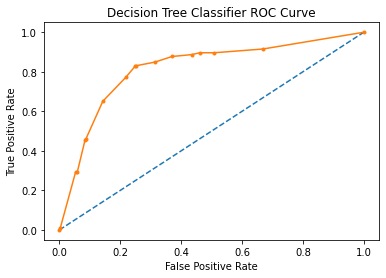

In [139]:
ns_probs = [0 for _ in range(len(y_test))]

probs = tree_cv.predict_proba(X_test_support)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Decision Tree Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [140]:
y_proba_tree = tree_cv.predict_proba(X_test_support)[:,1]
roc_auc_score(y_test,y_proba_tree)

0.81772142995305

The trained decision tree has achieved an ROC AUC score of 0.8177. The Youden's statistic provides us with the optimum threshold value where both specificity and sensitivity are maximised. We will calculate the threshold value at the Youden's statistic. 

In [141]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.6047211122159711

Text(0.251, 0.3, 'Youdens Statistic')

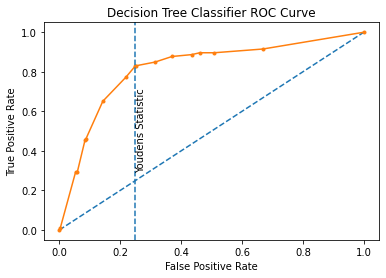

In [142]:
plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Decision Tree Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=fpr[np.where(thresholds==optimal_threshold)], linestyle='--')
plt.text(0.251,0.3,'Youdens Statistic',rotation=90)

Plotting this threshold value on the curve shows that it corresponds with the inflection point of the ROC curve. Using this threshold value, we can draw a set of predictions and calculate the classification report.

In [143]:
y_pred =(tree_cv.predict_proba(X_test_support)[:,1] >= optimal_threshold).astype(bool) # set threshold as 0.3

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1073
           1       0.25      0.83      0.38       106

    accuracy                           0.76      1179
   macro avg       0.61      0.79      0.62      1179
weighted avg       0.91      0.76      0.81      1179



From the above classification report, we can see that applying this threshold value to the model allows us to correctly identify 83% of diabetic cases. With a recall of 0.75, 25% of all non-diabetic cases get mis-classified, and given the 0.25 precision value of diabetic classes, 3 out of 4 subjects identified by the model do not have diabetes. 

However, in the practical application of this predictive model, subjects identified as at risk of diabetes may still require further testing to confirm that they meet the medical definitions for diagnosis. As such, the downside to a misclassification is non-lethal and might actually be helpful in identifying patients who may be prediabetic and in need of lifestyle modifications before their condition continues to develop further. 

To investigate the parameters that contribute to the identification of diabetes, we will plot the decision tree and look deeper into which parameters were selected as the most important at differentiating between diabetic and non-diabetic cases.  

[]

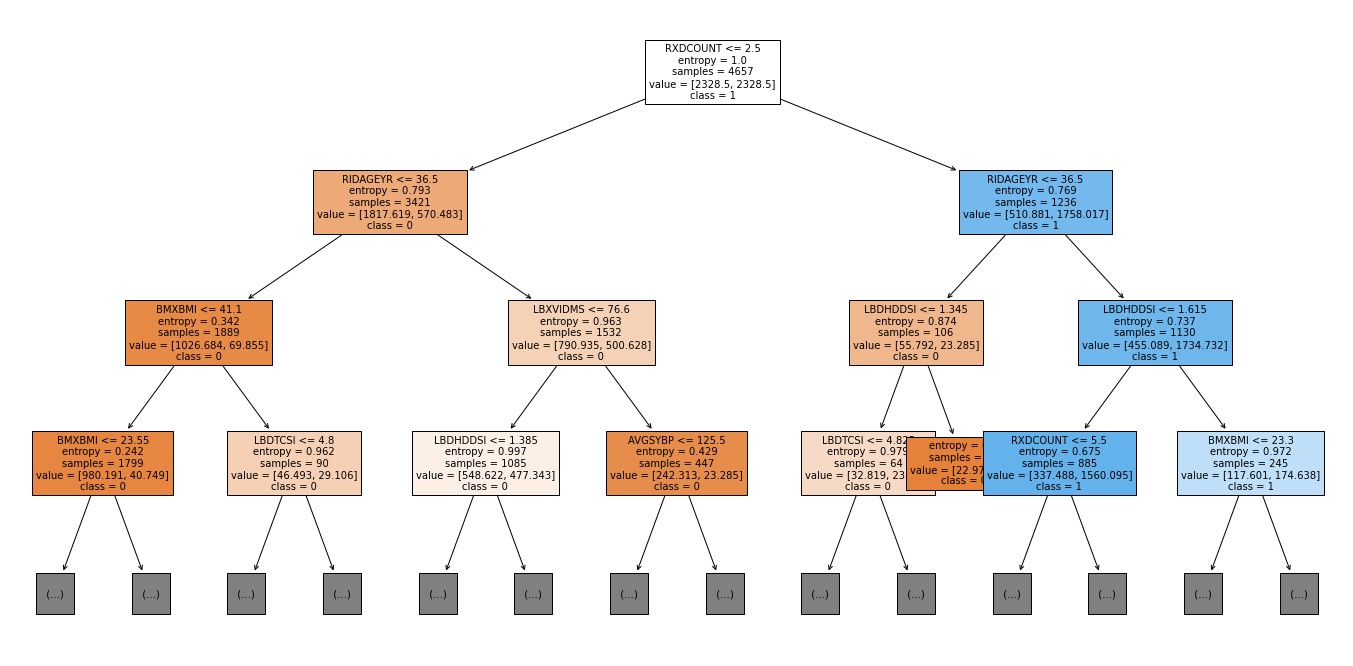

In [177]:
plt.figure(figsize=(24,12))
plot_tree(tree_cv.best_estimator_,max_depth=3,fontsize=10,feature_names = selected_features,class_names=['0','1'], filled=True)
plt.plot()

From the above visualisation of the tree, we can see that the variables RXDCOUNT (number of medications), RIDAGEYR (age in years), LBDHDDSI (HDL levels), BMXBMI (Body Mass Index) and LBXVIDMS (Serum vitamin D levels) seem to be important differentiating variables for diabetes. 

- RXDCOUNT as a variable may have been disproportionately indicative of diabetes because of the presence of diabetic-related medications in the subject records. The higher the number of medications that subjects are on, the higher the likelihood that one of the medications would be a diabetic drug. Given that our model is aimed at identifying diabetes before clinical diagnosis, including RXDCOUNT as one of the considered variables may offer an unfair advantage and we may have to remove the variable in a future iteration of the model. 

- The prevalence of diabetes increases with age and it is no surprise that RIDAGEYR is an important differentiating variable in this dataset. We can observe the decision tree model enforced a split to indicate that subjects aged 36.5 years and above have a higher likelihood of having diabetes. 

- Another variable of interest is LBDHDDSI, which is the serum HDL levels. HDL levels are an important measure of heart health and are often referred to as 'good cholesterol'. In this instance, we are able to see that the split identifying subjects who had HDL levels of 1.615 and below was able to separate a large proportion of diabetics. 

- BMXBMI is also an important variable distinguishing between classes. In the first 2 levels of the tree it is used to show that individuals with lower BMI will tend to have lower incidence of diabetes. This is consistent with public health literature which indicates that obesity is a strong risk factor for diabetes.

- The last variable of importance is LBXVIDMS. Vitamin D is often used as a proxy for healthy dietary practices or of an active lifestyle because the main 2 natural sources of Vitamin D is through whole foods such as fatty fish, egg yolks, liver, and through exposure to sunlight. Conversely, poor vitamin D levels may indicate poor dietary habits and a sedentary lifestyle. In this particular node, samples split because of lower serum vitamin D levels consist of a larger proportion of diabetics. This is also consistent with public health literature and shows the importance of vitamin D in predicting for diabetes.

## Random Forest

In [374]:
from sklearn.ensemble import RandomForestClassifier

In [375]:
rf_pipe = Pipeline(steps = [('preprocess',preprocessor), ('random_forest', RandomForestClassifier(random_state = 42, class_weight = 'balanced_subsample'))])

In [376]:
param_grid = { 
    'random_forest__n_estimators': [200,300,400,500],
    'random_forest__max_depth' : [4,5,6,7,8],
    'random_forest__criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=5, scoring = 'roc_auc')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('one-hot-encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['FSD151',
                                                                          'FSQ165',
                                                                          'INDHHIN2',
                                                                          'INDFMIN2',
                                                                          'mental_health_stat',
                                                                          'self_perception_stat',
                                                                          'activity_lvl']),
                                                                        ('standard-scaler',
    

Text(0, 0.5, 'True Positive Rate')

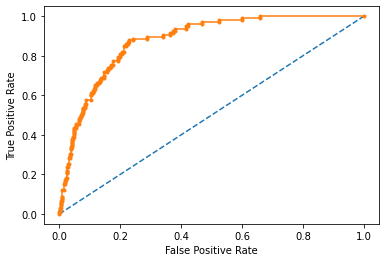

In [377]:
ns_probs = [0 for _ in range(len(y_test))]

probs = CV_rfc.predict_proba(X_test)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.', label='Random Forests Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [378]:
y_pred_rf = CV_rfc.predict(X_test)

roc_auc_score(y_test,y_pred_rf)

0.7539476692046633

In [379]:
CV_rfc.best_params_

{'random_forest__criterion': 'gini',
 'random_forest__max_depth': 8,
 'random_forest__n_estimators': 400}

In [380]:
rfc_bestpipe = Pipeline(steps = [('preprocess',preprocessor), ('random_forest', RandomForestClassifier(random_state = 42,criterion='gini',max_depth=8,n_estimators = 400,class_weight = 'balanced_subsample'))])

In [381]:
rfc_bestpipe.fit(X_train,y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FSD151', 'FSQ165',
                                                   'INDHHIN2', 'INDFMIN2',
                                                   'mental_health_stat',
                                                   'self_perception_stat',
                                                   'activity_lvl']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['RXDCOUNT', 'RIAGENDR',
                                                   'RIDAGEYR', 'RIDRETH1',
                                                   'BMXBMI', 'DR1TALCO',
                                                   'DR1.320Z', 'LBDHDDSI',
            

Text(0, 0.5, 'True Positive Rate')

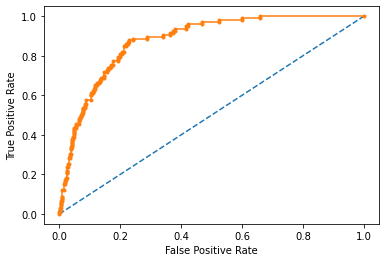

In [382]:
ns_probs = [0 for _ in range(len(y_test))]

probs = rfc_bestpipe.predict_proba(X_test)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.', label='Random Forests Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [383]:
y_pred_rfc_best = rfc_bestpipe.predict(X_test)
roc_auc_score(y_test, y_pred_rfc_best)

0.7539476692046633